# US Accidents Dataset - Exploratory Data Analysis

This notebook performs exploratory data analysis on the US Accidents dataset (2016-2023) from Kaggle.

## Objectives:

1. Analyze accident rates over time

2. Identify most common weather conditions per state

3. Examine severity trends by year

4. Create visualizations to understand patterns

In [3]:
#  Run the download script:
! python /Users/anemos/Desktop/us-accidents-risk/scripts/download_data.py

Starting download of US Accidents dataset...
Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
Dataset downloaded and extracted successfully!

Files in data directory:
  US_Accidents_March23.csv (2916.5 MB)

✅ Download completed successfully!


In [5]:
# Run the preprocessing script:
! python /Users/anemos/Desktop/us-accidents-risk/scripts/data_processing.py

Processing file: ../data/US_Accidents_March23.csv
Initialized processor for: ../data/US_Accidents_March23.csv
Loading data into DuckDB...
✅ Data loaded successfully!

📊 Data Integrity Report:
Total records: 7,728,394
Total columns: 46

Missing values in key columns:
  ID: 0 (0.0%)
  Start_Time: Error checking - Conversion Error: invalid timestamp field format: "", expected format is (YYYY-MM-DD HH:MM:SS[.US][±HH[:MM[:SS]]| ZONE])

LINE 3: ...                  WHERE "Start_Time" IS NULL OR "Start_Time" = ''
                                                                          ^
  State: 0 (0.0%)
  Severity: Error checking - Conversion Error: Could not convert string '' to INT64

LINE 3: ...                    WHERE "Severity" IS NULL OR "Severity" = ''
                                                                        ^
  Weather_Condition: 173,459 (2.2%)

Data ranges:
  Severity: 1 to 4 (4 unique values)
  Date range: 2016-01-14 20:18:33 to 2023-03-31 23:30:00
  Unique states:

In [31]:
# Run the risk analysis script:
! python /Users/anemos/Desktop/us-accidents-risk/scripts/risk_analysis.py

Analyzing file: ../data/US_Accidents_March23.csv
Loading data for risk analysis...
✅ Data loaded!

RISK ANALYSIS SUMMARY REPORT
Total accidents in dataset: 7,728,394
Data covers: 2016 - 2023

Top 10 states by total accidents:
   1. CA: 1,741,433
   2. FL: 880,192
   3. TX: 582,837
   4. SC: 382,557
   5. NY: 347,960
   6. NC: 338,199
   7. VA: 303,301
   8. PA: 296,620
   9. MN: 192,084
  10. OR: 179,660

Severity distribution:
  Severity 1: 67,366 (0.9%)
  Severity 2: 6,156,981 (79.7%)
  Severity 3: 1,299,337 (16.8%)
  Severity 4: 204,710 (2.6%)

Saving results to ../data/processed...
Computing risk metrics...
✅ Computed risk metrics: 25,730 records
  Saved risk_metrics: 25,730 records -> ../data/processed/risk_metrics.csv
  Saved detailed_risk_metrics: 66,678 records -> ../data/processed/detailed_risk_metrics.csv
  Saved annual_state_totals: 388 records -> ../data/processed/annual_state_totals.csv
  Saved severity_trends: 30 records -> ../data/processed/severity_trends.csv
  Saved we

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import duckdb
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Data Loading Strategy

# Define data paths
data_dir = Path("../data")
processed_dir = Path("../data/processed")

# Check if we have processed data from risk_analysis.py
if processed_dir.exists() and list(processed_dir.glob("*.csv")):
    print("Found processed data! Loading pre-computed metrics...")
    
    # Load pre-computed metrics (much faster)
    risk_metrics = pd.read_csv(processed_dir / "risk_metrics.csv")
    annual_totals = pd.read_csv(processed_dir / "annual_state_totals.csv")
    severity_trends = pd.read_csv(processed_dir / "severity_trends.csv")
    weather_by_state = pd.read_csv(processed_dir / "weather_by_state.csv")
    time_patterns = pd.read_csv(processed_dir / "time_patterns.csv")
    
    print("✅ Processed data loaded successfully!")
    print(f"   - Risk metrics: {len(risk_metrics):,} records")
    print(f"   - Annual totals: {len(annual_totals):,} records")
    print(f"   - Time patterns: {len(time_patterns):,} records")
    
    data_source = "processed"
    
else:
    print("⚠️  Processed data not found. Loading raw data with DuckDB...")
    print("   (This may take a few minutes for large datasets)")
    
    # Find the raw CSV file
    csv_files = list(data_dir.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("❌ No CSV files found. Please run download_data.py first!")
    
    data_file = csv_files[0]
    print(f"Loading: {data_file.name}")
    
    # Connect to DuckDB and load data
    conn = duckdb.connect()
    conn.execute(f"CREATE TABLE accidents AS SELECT * FROM read_csv_auto('{data_file}')")
    
    print("✅ Raw data loaded into DuckDB!")
    data_source = "raw"

Found processed data! Loading pre-computed metrics...
✅ Processed data loaded successfully!
   - Risk metrics: 26,721 records
   - Annual totals: 388 records
   - Time patterns: 14,411 records


In [12]:
# Quick Data Overview

print("="*60)
print("DATASET OVERVIEW")
print("="*60)

if data_source == "processed":
    # Using processed data
    total_accidents = annual_totals['total_accidents'].sum()
    year_range = f"{annual_totals['year'].min():.0f} - {annual_totals['year'].max():.0f}"
    num_states = annual_totals['State'].nunique()
    num_years = annual_totals['year'].nunique()
    
    print(f"Total accidents analyzed: {total_accidents:,}")
    print(f"Time period: {year_range}")
    print(f"States covered: {num_states}")
    print(f"Years of data: {num_years}")
    
    # Show sample of the data
    print(f"\nSample of annual totals data:")
    print(annual_totals.head())
    
else:
    # Using raw data
    total_records = conn.execute("SELECT COUNT(*) FROM accidents").fetchone()[0]
    print(f"Total records in dataset: {total_records:,}")
    
    # Get basic info about the raw data
    date_range = conn.execute("""
        SELECT MIN(Start_Time) as min_date, MAX(Start_Time) as max_date
        FROM accidents WHERE Start_Time IS NOT NULL
    """).fetchone()
    
    num_states = conn.execute("""
        SELECT COUNT(DISTINCT State) as unique_states
        FROM accidents WHERE State IS NOT NULL AND State != ''
    """).fetchone()[0]
    
    print(f"Date range: {date_range[0]} to {date_range[1]}")
    print(f" States covered: {num_states}")
    
    # Show sample of raw data
    sample_data = conn.execute("""
        SELECT ID, Start_Time, State, Severity, Weather_Condition
        FROM accidents LIMIT 5
    """).fetchdf()
    
    print(f"\nSample of raw data:")
    print(sample_data)

print(f"\n✅ Data overview completed!")
print(f"Using {data_source} data for analysis")

DATASET OVERVIEW
Total accidents analyzed: 7,728,394
Time period: 2016 - 2023
States covered: 49
Years of data: 8

Sample of annual totals data:
   year State  total_accidents
0  2016    CA           140452
1  2016    TX            49769
2  2016    FL            37060
3  2016    PA            21232
4  2016    NY            20097

✅ Data overview completed!
Using processed data for analysis


1. ANALYZING ACCIDENT TRENDS OVER TIME
Yearly accident totals:
   2016: 410,821 accidents
   2017: 718,093 accidents
   2018: 893,426 accidents
   2019: 954,303 accidents
   2020: 1,178,913 accidents
   2021: 1,563,753 accidents
   2022: 1,762,452 accidents
   2023: 246,633 accidents

Year-over-year percentage changes:
   2017: +74.8%
   2018: +24.4%
   2019: +6.8%
   2020: +23.5%
   2021: +32.6%
   2022: +12.7%
   2023: -86.0%


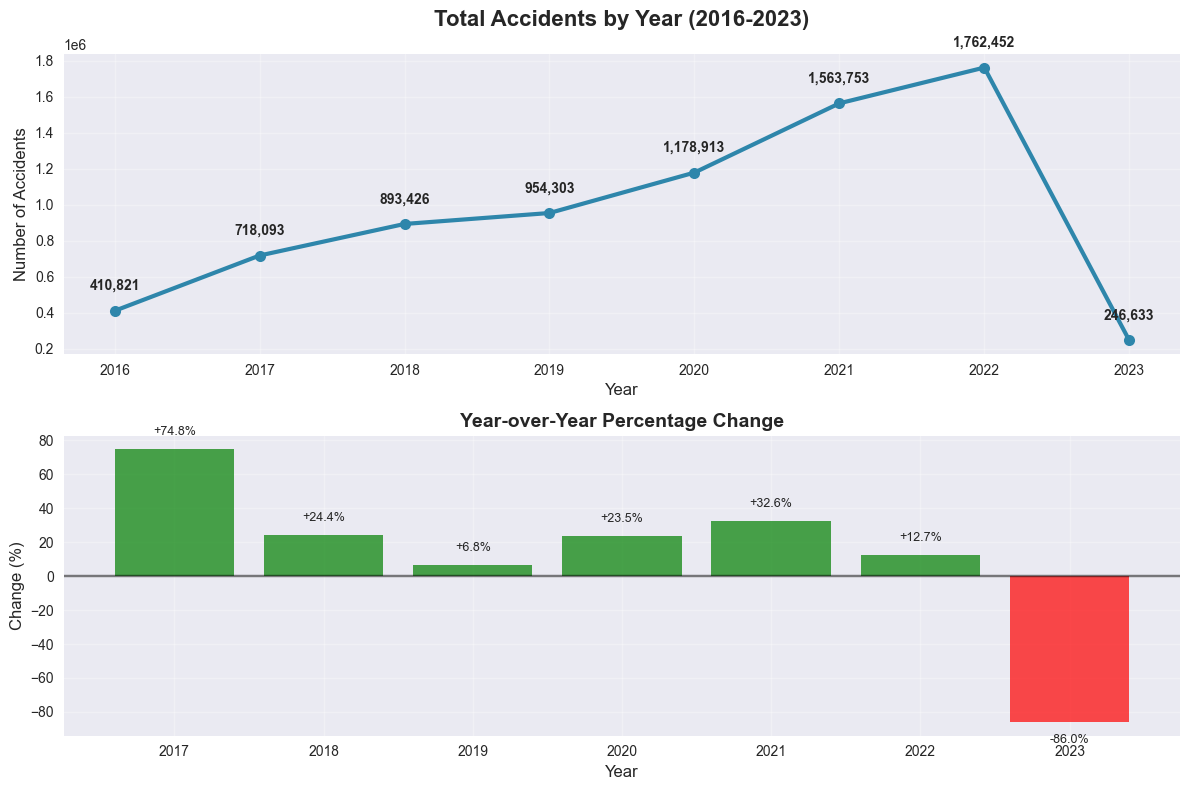


KEY INSIGHTS:
   Peak year: 2022 with 1,762,452.0 accidents
   Lowest year: 2023 with 246,633.0 accidents
   📈 Biggest increase: 2017 (+74.8%)
   📉 Biggest decrease: 2023 (-86.0%)


In [16]:
# Accident Trends Over Time

print("="*60)
print("1. ANALYZING ACCIDENT TRENDS OVER TIME")
print("="*60)

# Get yearly accident totals
if data_source == "processed":
    # Use pre-computed data
    yearly_totals = annual_totals.groupby('year')['total_accidents'].sum().reset_index()
else:
    # Query from raw data
    yearly_totals = conn.execute("""
        SELECT 
            EXTRACT(year FROM Start_Time::TIMESTAMP) as year,
            COUNT(*) as total_accidents
        FROM accidents 
        WHERE Start_Time IS NOT NULL
        GROUP BY year
        ORDER BY year
    """).fetchdf()

print(f"Yearly accident totals:")
for _, row in yearly_totals.iterrows():
    print(f"   {row['year']:.0f}: {row['total_accidents']:,} accidents")

# Calculate year-over-year changes
yearly_totals['yoy_change'] = yearly_totals['total_accidents'].pct_change() * 100
yearly_totals['yoy_absolute'] = yearly_totals['total_accidents'].diff()

print(f"\nYear-over-year percentage changes:")
for _, row in yearly_totals.iterrows():
    if pd.notna(row['yoy_change']):
        print(f"   {row['year']:.0f}: {row['yoy_change']:+.1f}%")

# Create the time series plot
plt.figure(figsize=(12, 8))

# Main line plot
plt.subplot(2, 1, 1)
plt.plot(yearly_totals['year'], yearly_totals['total_accidents'], 
         marker='o', linewidth=3, markersize=8, color='#2E86AB')
plt.title('Total Accidents by Year (2016-2023)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on points
for x, y in zip(yearly_totals['year'], yearly_totals['total_accidents']):
    plt.annotate(f'{y:,.0f}', (x, y), textcoords="offset points", 
                xytext=(0,15), ha='center', fontsize=10, fontweight='bold')

# Year-over-year change plot
plt.subplot(2, 1, 2)
colors = ['red' if x < 0 else 'green' for x in yearly_totals['yoy_change'][1:]]
plt.bar(yearly_totals['year'][1:], yearly_totals['yoy_change'][1:], color=colors, alpha=0.7)
plt.title('Year-over-Year Percentage Change', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add percentage labels
for i, (x, y) in enumerate(zip(yearly_totals['year'][1:], yearly_totals['yoy_change'][1:])):
    plt.annotate(f'{y:+.1f}%', (x, y), textcoords="offset points", 
                xytext=(0,10 if y > 0 else -15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Identify key insights
peak_year = yearly_totals.loc[yearly_totals['total_accidents'].idxmax()]
lowest_year = yearly_totals.loc[yearly_totals['total_accidents'].idxmin()]
biggest_increase = yearly_totals.loc[yearly_totals['yoy_change'].idxmax()]
biggest_decrease = yearly_totals.loc[yearly_totals['yoy_change'].idxmin()]

print(f"\nKEY INSIGHTS:")
print(f"   Peak year: {peak_year['year']:.0f} with {peak_year['total_accidents']:,} accidents")
print(f"   Lowest year: {lowest_year['year']:.0f} with {lowest_year['total_accidents']:,} accidents")
if pd.notna(biggest_increase['yoy_change']):
    print(f"   📈 Biggest increase: {biggest_increase['year']:.0f} (+{biggest_increase['yoy_change']:.1f}%)")
if pd.notna(biggest_decrease['yoy_change']):
    print(f"   📉 Biggest decrease: {biggest_decrease['year']:.0f} ({biggest_decrease['yoy_change']:.1f}%)")

# Store for later use
globals()['yearly_totals'] = yearly_totals

2. GEOGRAPHIC ANALYSIS - STATE PATTERNS
TOP 15 STATES BY TOTAL ACCIDENTS:
    1. CA: 1,741,433 accidents
    2. FL: 880,192 accidents
    3. TX: 582,837 accidents
    4. SC: 382,557 accidents
    5. NY: 347,960 accidents
    6. NC: 338,199 accidents
    7. VA: 303,301 accidents
    8. PA: 296,620 accidents
    9. MN: 192,084 accidents
   10. OR: 179,660 accidents
   11. AZ: 170,609 accidents
   12. GA: 169,234 accidents
   13. IL: 168,958 accidents
   14. TN: 167,388 accidents
   15. MI: 162,191 accidents

SUMMARY STATISTICS:
   • Total states: 49
   • Mean accidents per state: 157,722
   • Median accidents per state: 77,323
   • Most accidents (CA): 1,741,433
   • Fewest accidents: 289


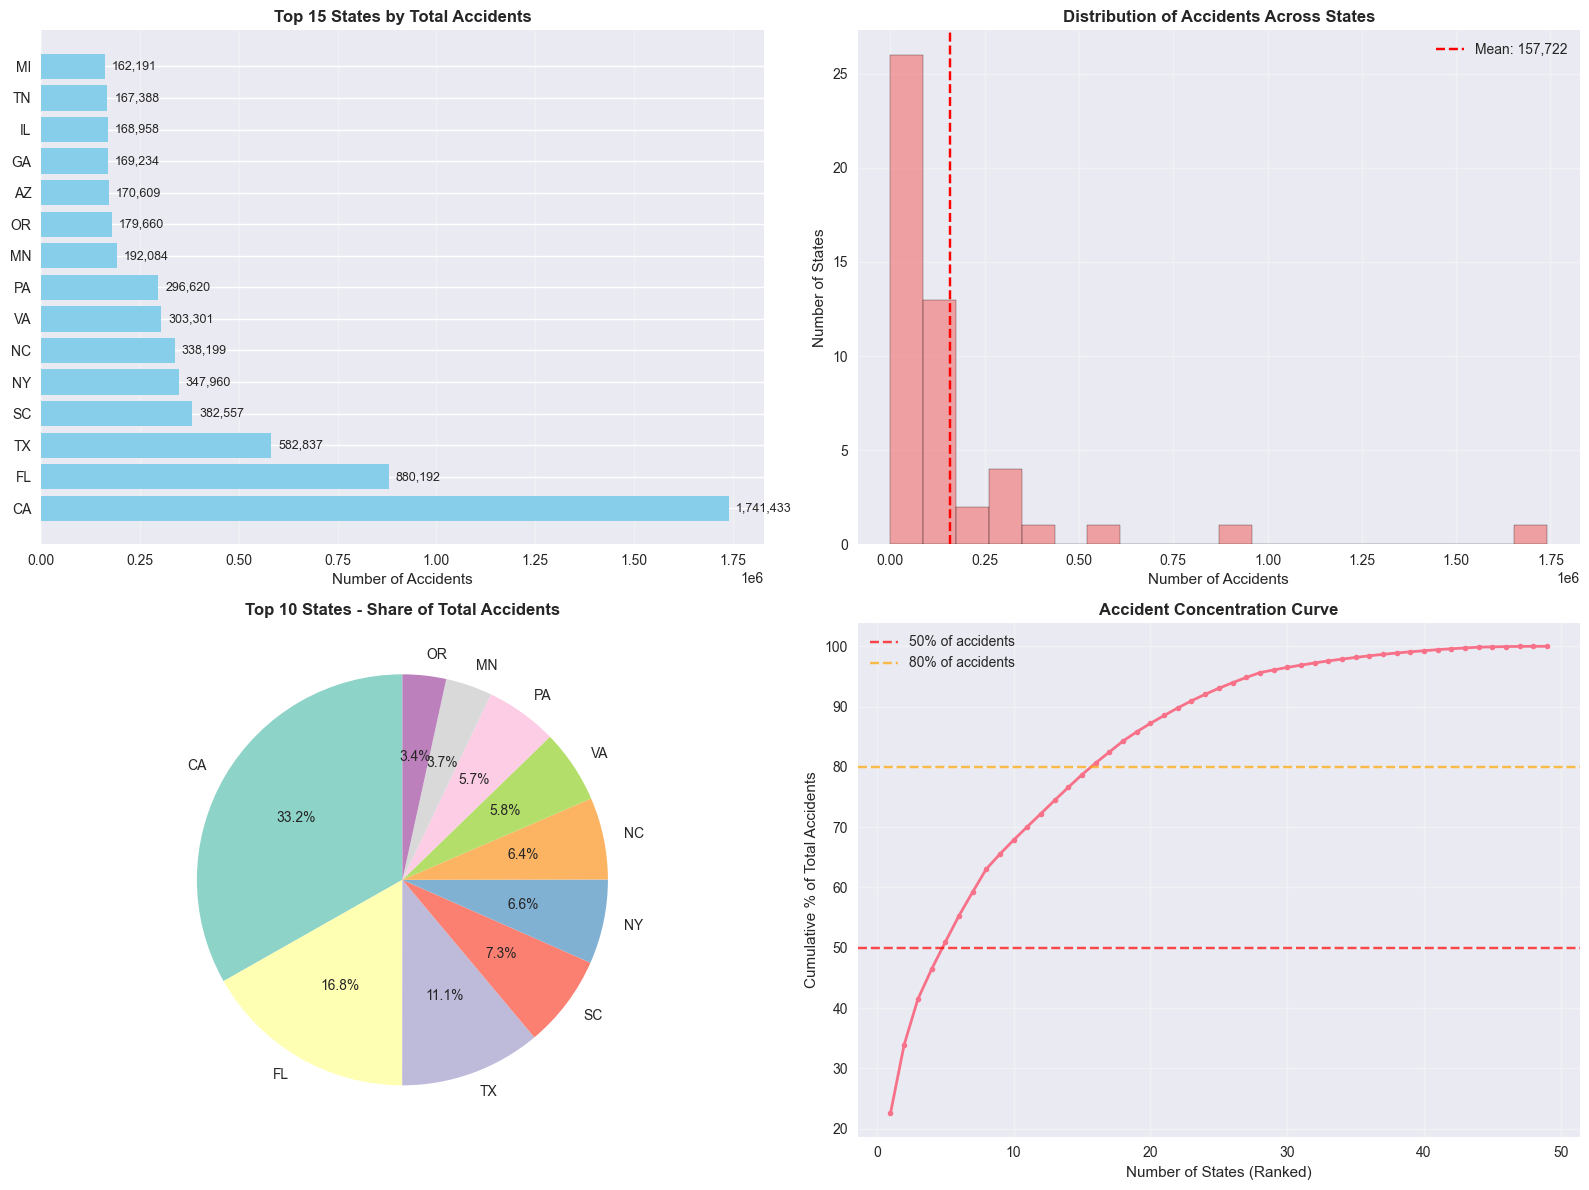


CONCENTRATION INSIGHTS:
   • Top 5 states account for 50.9% of all accidents
   • Top 10 states account for 67.9% of all accidents
   • Just 5 states account for 50% of all accidents
   • 16 states account for 80% of all accidents


In [18]:
# Geographic Analysis - State-Level Patterns

print("="*60)
print("2. GEOGRAPHIC ANALYSIS - STATE PATTERNS")
print("="*60)

# Get state-level totals
if data_source == "processed":
    state_totals = annual_totals.groupby('State')['total_accidents'].sum().sort_values(ascending=False)
else:
    state_totals = conn.execute("""
        SELECT State, COUNT(*) as total_accidents
        FROM accidents 
        WHERE State IS NOT NULL AND State != ''
        GROUP BY State 
        ORDER BY total_accidents DESC
    """).fetchdf().set_index('State')['total_accidents']

print(f"TOP 15 STATES BY TOTAL ACCIDENTS:")
top_15_states = state_totals.head(15)
for i, (state, count) in enumerate(top_15_states.items(), 1):
    print(f"   {i:2d}. {state}: {count:,} accidents")

print(f"\nSUMMARY STATISTICS:")
print(f"   • Total states: {len(state_totals)}")
print(f"   • Mean accidents per state: {state_totals.mean():,.0f}")
print(f"   • Median accidents per state: {state_totals.median():,.0f}")
print(f"   • Most accidents (CA): {state_totals.max():,}")
print(f"   • Fewest accidents: {state_totals.min():,}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 15 states bar chart
axes[0,0].barh(range(len(top_15_states)), top_15_states.values, color='skyblue')
axes[0,0].set_yticks(range(len(top_15_states)))
axes[0,0].set_yticklabels(top_15_states.index)
axes[0,0].set_xlabel('Number of Accidents')
axes[0,0].set_title('Top 15 States by Total Accidents', fontweight='bold')
axes[0,0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_15_states.values):
    axes[0,0].text(v + max(top_15_states.values)*0.01, i, f'{v:,}', 
                   va='center', fontsize=9)

# 2. Distribution histogram
axes[0,1].hist(state_totals.values, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Number of Accidents')
axes[0,1].set_ylabel('Number of States')
axes[0,1].set_title('Distribution of Accidents Across States', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Add mean line
axes[0,1].axvline(state_totals.mean(), color='red', linestyle='--', 
                  label=f'Mean: {state_totals.mean():,.0f}')
axes[0,1].legend()

# 3. Top 10 states with percentage of total
top_10_states = state_totals.head(10)
total_all_accidents = state_totals.sum()
percentages = (top_10_states / total_all_accidents * 100)

axes[1,0].pie(percentages.values, labels=percentages.index, autopct='%1.1f%%', 
              startangle=90, colors=plt.cm.Set3.colors)
axes[1,0].set_title('Top 10 States - Share of Total Accidents', fontweight='bold')

# 4. Accident concentration analysis
cumulative_pct = (state_totals.cumsum() / state_totals.sum() * 100)
axes[1,1].plot(range(1, len(cumulative_pct)+1), cumulative_pct.values, 
               marker='o', linewidth=2, markersize=4)
axes[1,1].set_xlabel('Number of States (Ranked)')
axes[1,1].set_ylabel('Cumulative % of Total Accidents')
axes[1,1].set_title('Accident Concentration Curve', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

# Add reference lines for key insights
top_5_pct = cumulative_pct.iloc[4]  # Top 5 states
top_10_pct = cumulative_pct.iloc[9]  # Top 10 states
axes[1,1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% of accidents')
axes[1,1].axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% of accidents')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Calculate concentration insights
states_for_50pct = (cumulative_pct <= 50).sum() + 1
states_for_80pct = (cumulative_pct <= 80).sum() + 1

print(f"\nCONCENTRATION INSIGHTS:")
print(f"   • Top 5 states account for {top_5_pct:.1f}% of all accidents")
print(f"   • Top 10 states account for {top_10_pct:.1f}% of all accidents")
print(f"   • Just {states_for_50pct} states account for 50% of all accidents")
print(f"   • {states_for_80pct} states account for 80% of all accidents")

# Store for later use
globals()['state_totals'] = state_totals
globals()['top_10_states'] = top_10_states.index.tolist()

3. WEATHER CONDITIONS ANALYSIS
🌤️  TOP 10 WEATHER CONDITIONS (Overall):
    1. Fair: 2,560,802 (43.0%)
    2. Mostly Cloudy: 1,015,368 (17.1%)
    3. Clear: 802,151 (13.5%)
    4. Cloudy: 800,955 (13.5%)
    5. Partly Cloudy: 612,315 (10.3%)
    6. Overcast: 80,285 (1.3%)
    7. Light Rain: 44,823 (0.8%)
    8. Light Snow: 34,979 (0.6%)
    9. Scattered Clouds: 2,723 (0.0%)
   10. Fair / Windy: 255 (0.0%)


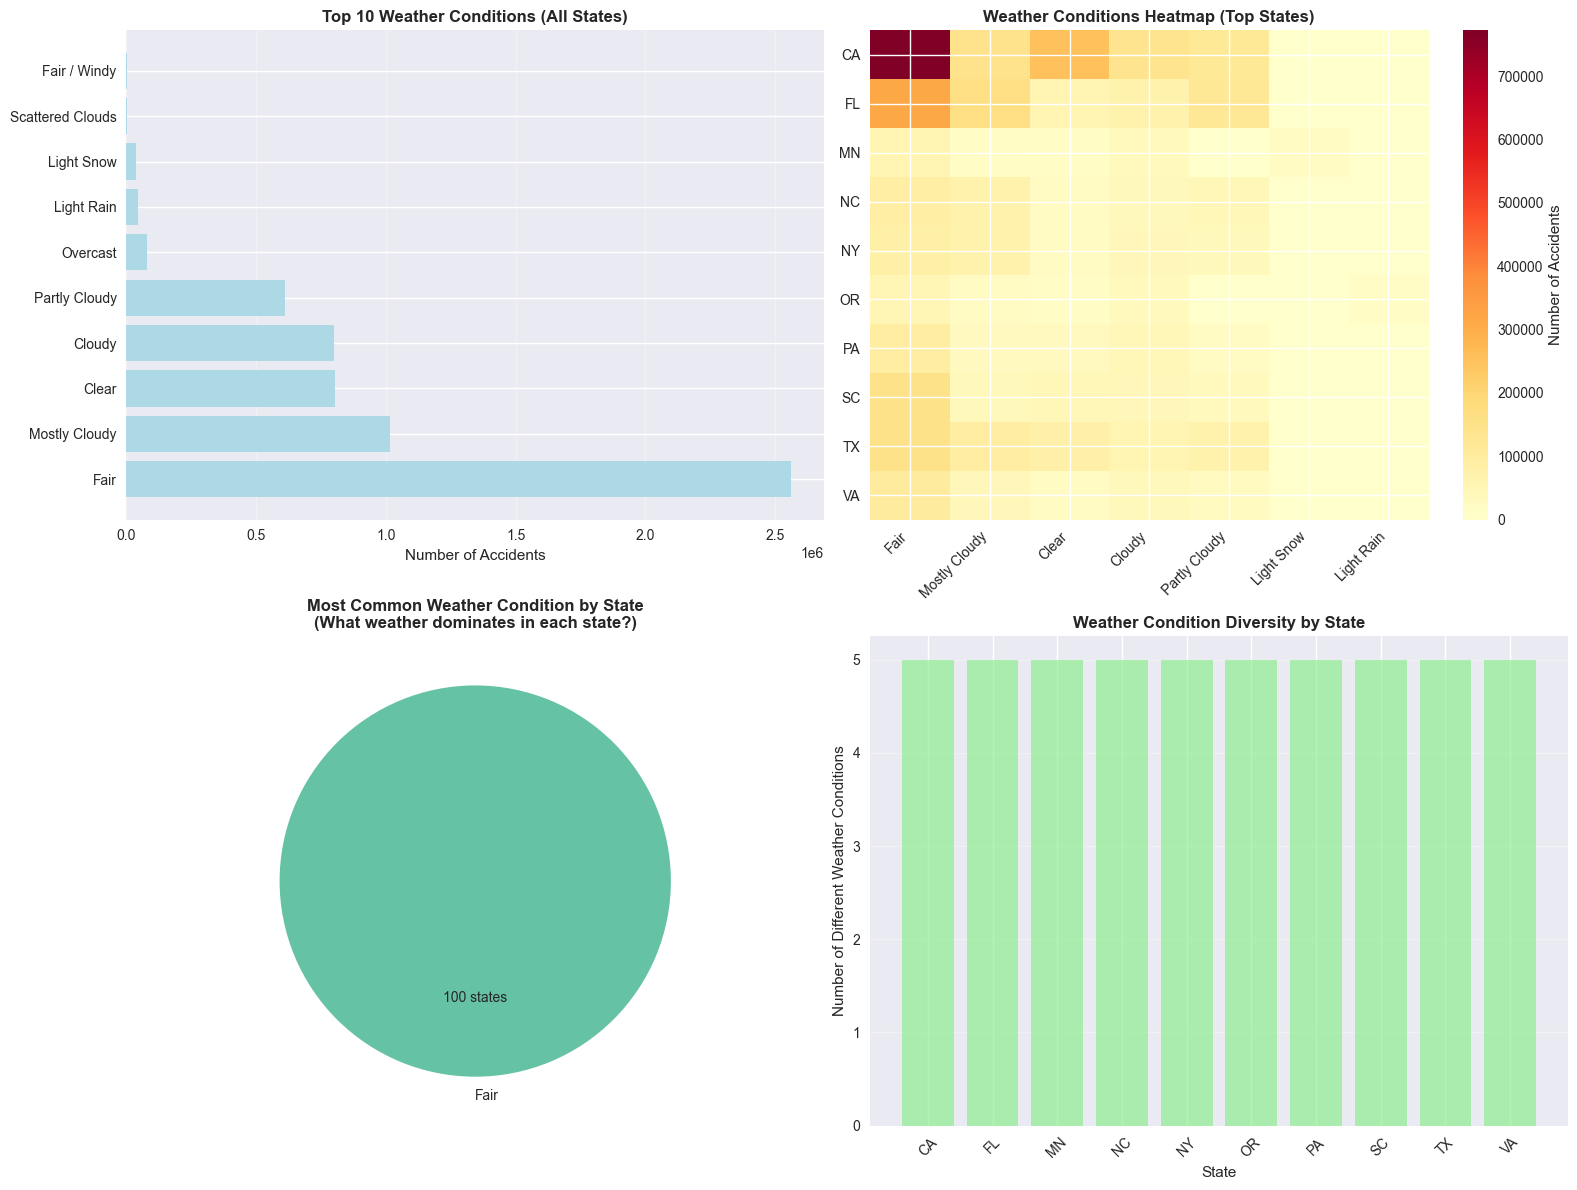


MOST COMMON WEATHER CONDITION BY STATE (Top 10 States):
   CA: Fair (772,394 accidents)
   FL: Fair (316,249 accidents)
   MN: Fair (58,458 accidents)
   NC: Fair (89,292 accidents)
   NY: Fair (81,307 accidents)
   OR: Fair (48,708 accidents)
   PA: Fair (92,802 accidents)
   SC: Fair (144,992 accidents)
   TX: Fair (149,144 accidents)
   VA: Fair (102,762 accidents)

 WEATHER INSIGHTS:
   • 10 states have clear weather as most common accident condition
   • 0 states have cloudy weather as most common accident condition
   • Weather diversity ranges from 5 to 5 conditions per state
   • Clear weather dominates in: CA, FL, MN, NC, NY...


In [20]:
# Weather Conditions Analysis

print("="*60)
print("3. WEATHER CONDITIONS ANALYSIS")
print("="*60)

# Get weather data
if data_source == "processed":
    weather_data = weather_by_state.copy()
else:
    weather_data = conn.execute("""
        WITH weather_counts AS (
            SELECT 
                State,
                Weather_Condition,
                COUNT(*) as accident_count,
                ROW_NUMBER() OVER (PARTITION BY State ORDER BY COUNT(*) DESC) as rn
            FROM accidents 
            WHERE State IS NOT NULL AND State != ''
                AND Weather_Condition IS NOT NULL AND Weather_Condition != ''
            GROUP BY State, Weather_Condition
        )
        SELECT State, Weather_Condition, accident_count
        FROM weather_counts 
        WHERE rn <= 5  -- Top 5 per state
        ORDER BY State, accident_count DESC
    """).fetchdf()

# Overall weather condition analysis
overall_weather = weather_data.groupby('Weather_Condition')['accident_count'].sum().sort_values(ascending=False)

print(f"🌤️  TOP 10 WEATHER CONDITIONS (Overall):")
top_weather = overall_weather.head(10)
total_weather_accidents = overall_weather.sum()

for i, (weather, count) in enumerate(top_weather.items(), 1):
    pct = (count / total_weather_accidents) * 100
    print(f"   {i:2d}. {weather}: {count:,} ({pct:.1f}%)")

# Focus on top 10 states for detailed analysis
if 'top_10_states' in globals():
    weather_top_states = weather_data[weather_data['State'].isin(top_10_states)]
else:
    # Get top 10 states if not already calculated
    if data_source == "processed":
        top_states_list = annual_totals.groupby('State')['total_accidents'].sum().nlargest(10).index.tolist()
    else:
        top_states_list = conn.execute("""
            SELECT State FROM (
                SELECT State, COUNT(*) as total
                FROM accidents WHERE State IS NOT NULL AND State != ''
                GROUP BY State ORDER BY total DESC LIMIT 10
            )
        """).fetchdf()['State'].tolist()
    
    weather_top_states = weather_data[weather_data['State'].isin(top_states_list)]

# Create weather analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall weather conditions bar chart
axes[0,0].barh(range(len(top_weather)), top_weather.values, color='lightblue')
axes[0,0].set_yticks(range(len(top_weather)))
axes[0,0].set_yticklabels([label[:20] + '...' if len(label) > 20 else label 
                          for label in top_weather.index])
axes[0,0].set_xlabel('Number of Accidents')
axes[0,0].set_title('Top 10 Weather Conditions (All States)', fontweight='bold')
axes[0,0].grid(True, alpha=0.3, axis='x')

# 2. Heatmap of weather vs states (top states only)
weather_pivot = weather_top_states.pivot_table(
    values='accident_count', 
    index='State', 
    columns='Weather_Condition', 
    fill_value=0
)

# Select top weather conditions for the heatmap (to avoid clutter)
top_weather_conditions = weather_top_states.groupby('Weather_Condition')['accident_count'].sum().nlargest(8).index
weather_pivot_filtered = weather_pivot[top_weather_conditions]

im = axes[0,1].imshow(weather_pivot_filtered.values, cmap='YlOrRd', aspect='auto')
axes[0,1].set_xticks(range(len(weather_pivot_filtered.columns)))
axes[0,1].set_xticklabels([col[:15] + '...' if len(col) > 15 else col 
                          for col in weather_pivot_filtered.columns], rotation=45, ha='right')
axes[0,1].set_yticks(range(len(weather_pivot_filtered.index)))
axes[0,1].set_yticklabels(weather_pivot_filtered.index)
axes[0,1].set_title('Weather Conditions Heatmap (Top States)', fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=axes[0,1], label='Number of Accidents')

# 3. Most common weather by state
most_common_weather = weather_top_states.loc[
    weather_top_states.groupby('State')['accident_count'].idxmax()
]

state_weather_counts = most_common_weather.groupby('Weather_Condition').size()
axes[1,0].pie(state_weather_counts.values, labels=state_weather_counts.index, 
              autopct='%1.0f states', startangle=90, colors=plt.cm.Set2.colors)
axes[1,0].set_title('Most Common Weather Condition by State\n(What weather dominates in each state?)', 
                    fontweight='bold')

# 4. Weather diversity by state
weather_diversity = weather_top_states.groupby('State').size()
axes[1,1].bar(weather_diversity.index, weather_diversity.values, color='lightgreen', alpha=0.7)
axes[1,1].set_xlabel('State')
axes[1,1].set_ylabel('Number of Different Weather Conditions')
axes[1,1].set_title('Weather Condition Diversity by State', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Detailed state-weather analysis
print(f"\nMOST COMMON WEATHER CONDITION BY STATE (Top 10 States):")
for _, row in most_common_weather.iterrows():
    print(f"   {row['State']}: {row['Weather_Condition']} ({row['accident_count']:,} accidents)")

# Weather insights
clear_weather_states = most_common_weather[
    most_common_weather['Weather_Condition'].str.contains('Clear|Fair', case=False, na=False)
]['State'].tolist()

cloudy_weather_states = most_common_weather[
    most_common_weather['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na=False)
]['State'].tolist()

print(f"\n WEATHER INSIGHTS:")
print(f"   • {len(clear_weather_states)} states have clear weather as most common accident condition")
print(f"   • {len(cloudy_weather_states)} states have cloudy weather as most common accident condition")
print(f"   • Weather diversity ranges from {weather_diversity.min()} to {weather_diversity.max()} conditions per state")

if clear_weather_states:
    print(f"   • Clear weather dominates in: {', '.join(clear_weather_states[:5])}{'...' if len(clear_weather_states) > 5 else ''}")

# Store for later use
globals()['weather_data'] = weather_data
globals()['top_weather'] = top_weather

4. ACCIDENT SEVERITY ANALYSIS
 OVERALL SEVERITY DISTRIBUTION:
   Severity 1 (Minor): 67,366 accidents (0.9%)
   Severity 2 (Moderate): 6,156,981 accidents (79.7%)
   Severity 3 (Serious): 1,299,337 accidents (16.8%)
   Severity 4 (Severe): 204,710 accidents (2.6%)

SEVERITY DISTRIBUTION FOR 2023:
   Severity 2: 239,572 (97.1%)
   Severity 4: 7,061 (2.9%)


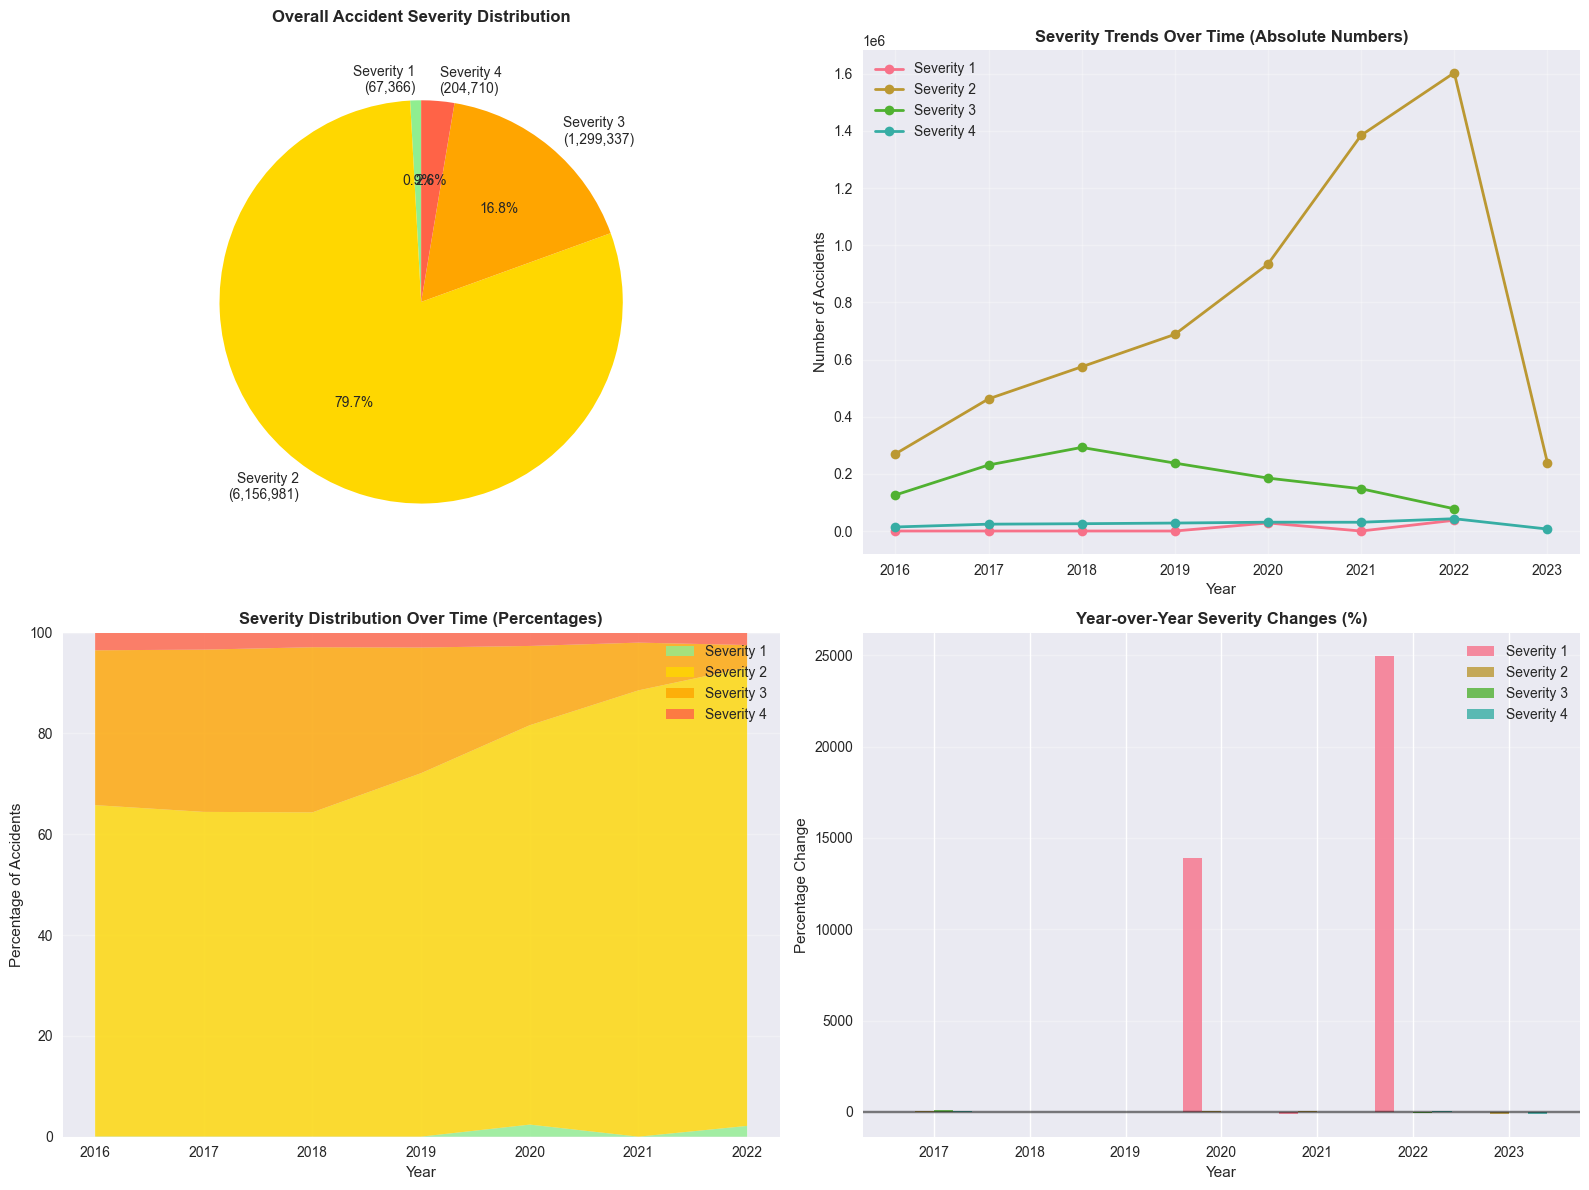


SEVERITY TRENDS ANALYSIS (2016 to 2023):
   Severity 1: 225 (2016) → 37,875 (2022) (+16733.3%) ↑
      Data available for 7/8 years
   Severity 2: 270,026 (2016) → 239,572 (2023) (-11.3%) ↓
      Data available for 8/8 years
   Severity 3: 126,215 (2016) → 77,957 (2022) (-38.2%) ↓
      Data available for 7/8 years
   Severity 4: 14,355 (2016) → 7,061 (2023) (-50.8%) ↓
      Data available for 8/8 years

STATES WITH HIGHEST SEVERE ACCIDENT RATES (Severity 3+4):
   RI: 46.2% severe accidents
   GA: 43.7% severe accidents
   KY: 42.5% severe accidents
   WI: 37.7% severe accidents
   CO: 37.2% severe accidents
   IL: 36.7% severe accidents
   MO: 36.6% severe accidents
   IA: 34.3% severe accidents
   VT: 33.2% severe accidents
   NM: 33.1% severe accidents

STATES WITH LOWEST SEVERE ACCIDENT RATES (Severity 3+4):
   ND: 0.9% severe accidents
   MT: 2.1% severe accidents
   ID: 6.8% severe accidents
   OR: 8.7% severe accidents
   OK: 8.7% severe accidents
   WV: 9.8% severe accidents
 

In [37]:
# Accident Severity Analysis

print("="*60)
print("4. ACCIDENT SEVERITY ANALYSIS")
print("="*60)

# Get severity data
if data_source == "processed":
    severity_data = severity_trends.copy()
else:
    severity_data = conn.execute("""
        SELECT 
            EXTRACT(year FROM Start_Time::TIMESTAMP) as year,
            Severity,
            COUNT(*) as accident_count,
            COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY EXTRACT(year FROM Start_Time::TIMESTAMP)) as percentage
        FROM accidents 
        WHERE Start_Time IS NOT NULL AND Severity IS NOT NULL
        GROUP BY year, Severity
        ORDER BY year, Severity
    """).fetchdf()

# Overall severity distribution
overall_severity = severity_data.groupby('Severity')['accident_count'].sum()
total_severity_accidents = overall_severity.sum()

print(f" OVERALL SEVERITY DISTRIBUTION:")
for severity, count in overall_severity.items():
    pct = (count / total_severity_accidents) * 100
    severity_desc = {1: "Minor", 2: "Moderate", 3: "Serious", 4: "Severe"}
    desc = severity_desc.get(severity, "Unknown")
    print(f"   Severity {severity} ({desc}): {count:,} accidents ({pct:.1f}%)")

# Latest year analysis
latest_year = severity_data['year'].max()
latest_severity = severity_data[severity_data['year'] == latest_year].copy()

print(f"\nSEVERITY DISTRIBUTION FOR {latest_year:.0f}:")
for _, row in latest_severity.iterrows():
    print(f"   Severity {row['Severity']:.0f}: {row['accident_count']:,.0f} ({row['percentage']:.1f}%)")

# Create comprehensive severity visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall severity distribution (pie chart)
severity_labels = [f"Severity {s}\n({overall_severity[s]:,})" for s in overall_severity.index]
colors = ['#90EE90', '#FFD700', '#FFA500', '#FF6347']  # Light green to red
axes[0,0].pie(overall_severity.values, labels=severity_labels, autopct='%1.1f%%', 
              startangle=90, colors=colors)
axes[0,0].set_title('Overall Accident Severity Distribution', fontweight='bold', pad=20)

# 2. Severity trends over time (line plot)
severity_pivot = severity_data.pivot(index='year', columns='Severity', values='accident_count')
for severity in severity_pivot.columns:
    axes[0,1].plot(severity_pivot.index, severity_pivot[severity], 
                   marker='o', linewidth=2, label=f'Severity {severity}')
axes[0,1].set_title('Severity Trends Over Time (Absolute Numbers)', fontweight='bold')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Number of Accidents')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Severity percentage trends (stacked area)
severity_pct_pivot = severity_data.pivot(index='year', columns='Severity', values='percentage')
axes[1,0].stackplot(severity_pct_pivot.index, 
                    severity_pct_pivot[1], severity_pct_pivot[2], 
                    severity_pct_pivot[3], severity_pct_pivot[4],
                    labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
                    colors=colors, alpha=0.8)
axes[1,0].set_title('Severity Distribution Over Time (Percentages)', fontweight='bold')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Percentage of Accidents')
axes[1,0].legend(loc='upper right')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_ylim(0, 100)

# 4. Year-over-year severity changes
severity_changes = severity_pivot.pct_change() * 100
severity_changes = severity_changes.dropna()

x = range(len(severity_changes))
width = 0.2
for i, severity in enumerate(severity_changes.columns):
    axes[1,1].bar([pos + width*i for pos in x], severity_changes[severity], 
                  width, label=f'Severity {severity}', alpha=0.8)

axes[1,1].set_title('Year-over-Year Severity Changes (%)', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Percentage Change')
axes[1,1].set_xticks([pos + width*1.5 for pos in x])
axes[1,1].set_xticklabels([f'{year:.0f}' for year in severity_changes.index])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate severity insights
severity_trend_analysis = {}
for severity in severity_pivot.columns:
    # Use dropna() to handle missing values properly
    valid_data = severity_pivot[severity].dropna()
    
    if len(valid_data) >= 2:  # Need at least 2 data points for trend analysis
        first_year_value = valid_data.iloc[0]
        last_year_value = valid_data.iloc[-1]
        first_year_date = valid_data.index[0]
        last_year_date = valid_data.index[-1]
        
        total_change = ((last_year_value - first_year_value) / first_year_value) * 100
        
        severity_trend_analysis[severity] = {
            'first_year': first_year_value,
            'last_year': last_year_value,
            'total_change': total_change,
            'first_year_date': first_year_date,
            'last_year_date': last_year_date,
            'data_points': len(valid_data)
        }
    else:
        # Insufficient data for trend analysis
        severity_trend_analysis[severity] = {
            'first_year': float('nan'),
            'last_year': float('nan'),
            'total_change': float('nan'),
            'first_year_date': None,
            'last_year_date': None,
            'data_points': len(valid_data)
        }

print(f"\nSEVERITY TRENDS ANALYSIS ({severity_pivot.index.min():.0f} to {severity_pivot.index.max():.0f}):")
for severity, data in severity_trend_analysis.items():
    if data['data_points'] >= 2 and pd.notna(data['total_change']):
        trend_symbol = "↑" if data['total_change'] > 0 else "↓"
        print(f"   Severity {severity}: {data['first_year']:,.0f} ({data['first_year_date']:.0f}) → " +
              f"{data['last_year']:,.0f} ({data['last_year_date']:.0f}) " +
              f"({data['total_change']:+.1f}%) {trend_symbol}")
        print(f"      Data available for {data['data_points']}/{len(severity_pivot)} years")
    elif data['data_points'] == 1:
        only_value = severity_pivot[severity].dropna().iloc[0]
        only_year = severity_pivot[severity].dropna().index[0]
        print(f"   Severity {severity}: Only data for {only_year:.0f} ({only_value:,.0f} accidents)")
    else:
        print(f"   Severity {severity}: Insufficient data for trend analysis")

# Most/least severe states analysis
if data_source == "processed":
    # Calculate severity rates by state
    state_severity = risk_metrics.groupby(['State', 'Severity'])['accident_count'].sum().unstack(fill_value=0)
    state_severity['total'] = state_severity.sum(axis=1)
    state_severity['severity_3_4_rate'] = (state_severity[3] + state_severity[4]) / state_severity['total'] * 100
    
    print(f"\nSTATES WITH HIGHEST SEVERE ACCIDENT RATES (Severity 3+4):")
    top_severe_states = state_severity.nlargest(10, 'severity_3_4_rate')
    for state, row in top_severe_states.iterrows():
        print(f"   {state}: {row['severity_3_4_rate']:.1f}% severe accidents")
    
    print(f"\nSTATES WITH LOWEST SEVERE ACCIDENT RATES (Severity 3+4):")
    low_severe_states = state_severity.nsmallest(10, 'severity_3_4_rate')
    for state, row in low_severe_states.iterrows():
        print(f"   {state}: {row['severity_3_4_rate']:.1f}% severe accidents")

# Key insights summary
most_common_severity = overall_severity.idxmax()
least_common_severity = overall_severity.idxmin()
high_severity_rate = ((overall_severity[3] + overall_severity[4]) / total_severity_accidents) * 100

print(f"\nKEY SEVERITY INSIGHTS:")
print(f"   • Most common severity: Level {most_common_severity} ({(overall_severity[most_common_severity]/total_severity_accidents*100):.1f}%)")
print(f"   • Least common severity: Level {least_common_severity} ({(overall_severity[least_common_severity]/total_severity_accidents*100):.1f}%)")
print(f"   • High severity rate (3+4): {high_severity_rate:.1f}% of all accidents")
print(f"   • Low severity rate (1+2): {100-high_severity_rate:.1f}% of all accidents")

# Store for later use
globals()['severity_data'] = severity_data
globals()['overall_severity'] = overall_severity

5. TIME PATTERN ANALYSIS
PEAK ACCIDENT TIMES:
   Peak hour: 7:00 (587,472 accidents)
   Peak month: Dec (847,343 accidents)
   Peak day: Friday (1,366,499 accidents)


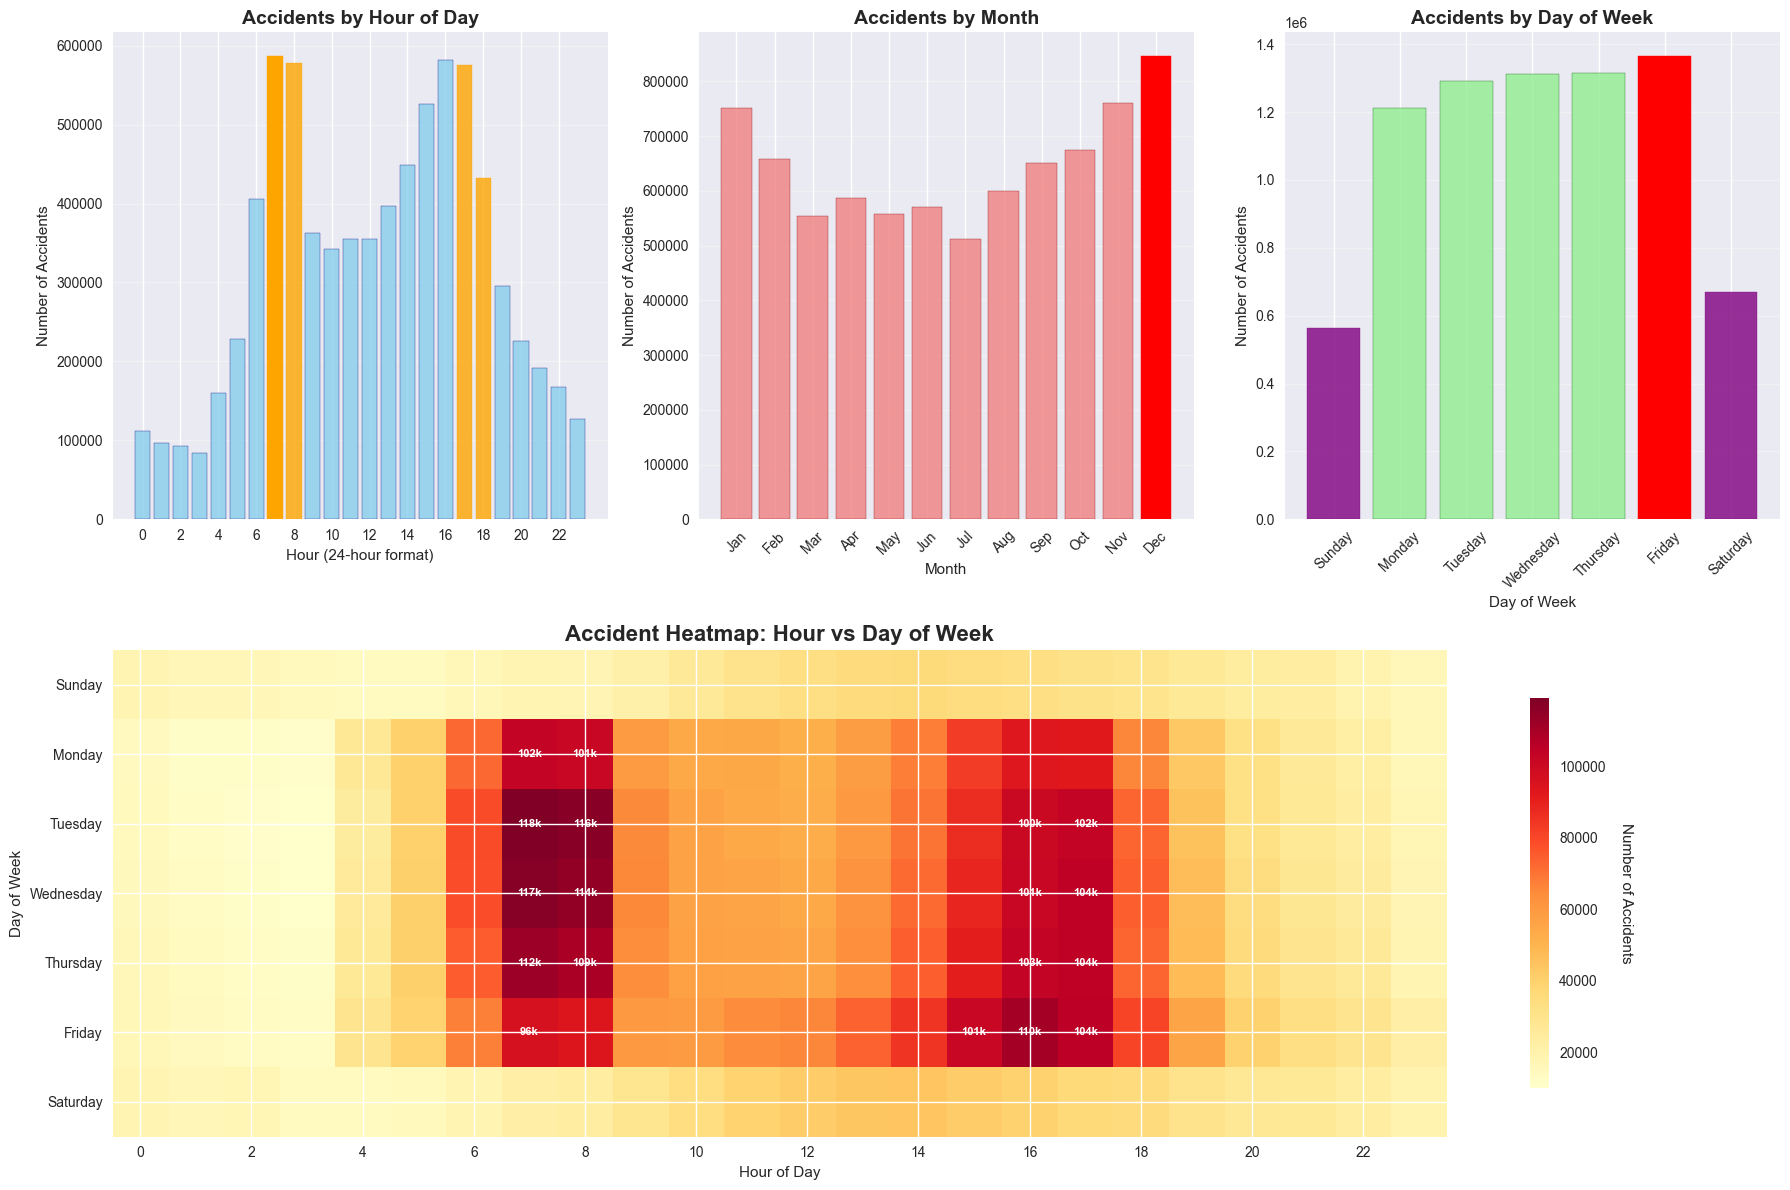


RUSH HOUR ANALYSIS:
   Morning rush (6-9 AM): 1,933,919 accidents (25.0%)
   Evening rush (4-7 PM): 1,885,147 accidents (24.4%)
   Total rush hour accidents: 3,819,066 (49.4%)

WEEKDAY vs WEEKEND ANALYSIS:
   Weekday accidents: 6,496,967 (84.1%)
   Weekend accidents: 1,231,427 (15.9%)
   Average per weekday: 1,299,393
   Average per weekend day: 615,714

SEASONAL ANALYSIS:
   Fall: 2,086,676 accidents (27.0%)
   Spring: 1,700,071 accidents (22.0%)
   Summer: 1,683,374 accidents (21.8%)
   Winter: 2,258,273 accidents (29.2%)

SAFEST TIMES:
   Safest hour: 3:00 (83,863 accidents)
   Safest month: Jul (512,335 accidents)
   Safest day: Sunday (562,744 accidents)


In [ ]:
# Time Pattern Analysis

print("="*60)
print("5. TIME PATTERN ANALYSIS")
print("="*60)

# Get time pattern data
if data_source == "processed":
    time_data = time_patterns.copy()
else:
    time_data = conn.execute("""
        SELECT 
            EXTRACT(year FROM Start_Time::TIMESTAMP) as year,
            EXTRACT(month FROM Start_Time::TIMESTAMP) as month,
            EXTRACT(hour FROM Start_Time::TIMESTAMP) as hour,
            EXTRACT(dow FROM Start_Time::TIMESTAMP) as day_of_week,
            COUNT(*) as accident_count
        FROM accidents 
        WHERE Start_Time IS NOT NULL
        GROUP BY year, month, hour, day_of_week
        ORDER BY year, month, hour
    """).fetchdf()

# Calculate different time aggregations
hourly_accidents = time_data.groupby('hour')['accident_count'].sum().reset_index()
monthly_accidents = time_data.groupby('month')['accident_count'].sum().reset_index()
dow_accidents = time_data.groupby('day_of_week')['accident_count'].sum().reset_index()

# Add readable names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_accidents['month_name'] = [month_names[int(m)-1] for m in monthly_accidents['month']]

dow_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dow_accidents['day_name'] = [dow_names[int(d)] for d in dow_accidents['day_of_week']]

print(f"PEAK ACCIDENT TIMES:")
peak_hour = hourly_accidents.loc[hourly_accidents['accident_count'].idxmax()]
peak_month = monthly_accidents.loc[monthly_accidents['accident_count'].idxmax()]
peak_dow = dow_accidents.loc[dow_accidents['accident_count'].idxmax()]

print(f"   Peak hour: {peak_hour['hour']:.0f}:00 ({peak_hour['accident_count']:,} accidents)")
print(f"   Peak month: {peak_month['month_name']} ({peak_month['accident_count']:,} accidents)")
print(f"   Peak day: {peak_dow['day_name']} ({peak_dow['accident_count']:,} accidents)")

# Create comprehensive time pattern visualizations
fig = plt.figure(figsize=(18, 12))

# 1. Hourly pattern
ax1 = plt.subplot(2, 3, 1)
bars = plt.bar(hourly_accidents['hour'], hourly_accidents['accident_count'], 
               color='skyblue', alpha=0.8, edgecolor='navy')
plt.title('Accidents by Hour of Day', fontweight='bold', fontsize=14)
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Accidents')
plt.grid(True, alpha=0.3, axis='y')

# Highlight peak hours
max_hour = hourly_accidents.loc[hourly_accidents['accident_count'].idxmax(), 'hour']
bars[int(max_hour)].set_color('red')
bars[int(max_hour)].set_alpha(1.0)

# Add rush hour indicators
rush_hours = [7, 8, 17, 18]  # Morning and evening rush
for hour in rush_hours:
    if hour < len(bars):
        bars[int(hour)].set_color('orange')

plt.xticks(range(0, 24, 2))

# 2. Monthly pattern
ax2 = plt.subplot(2, 3, 2)
bars = plt.bar(monthly_accidents['month_name'], monthly_accidents['accident_count'], 
               color='lightcoral', alpha=0.8, edgecolor='darkred')
plt.title('Accidents by Month', fontweight='bold', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Highlight peak month
max_month_idx = monthly_accidents['accident_count'].idxmax()
bars[max_month_idx].set_color('red')
bars[max_month_idx].set_alpha(1.0)

# 3. Day of week pattern
ax3 = plt.subplot(2, 3, 3)
bars = plt.bar(dow_accidents['day_name'], dow_accidents['accident_count'], 
               color='lightgreen', alpha=0.8, edgecolor='darkgreen')
plt.title('Accidents by Day of Week', fontweight='bold', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Highlight weekdays vs weekends
weekend_days = ['Saturday', 'Sunday']
for i, day in enumerate(dow_accidents['day_name']):
    if day in weekend_days:
        bars[i].set_color('purple')

max_dow_idx = dow_accidents['accident_count'].idxmax()
bars[max_dow_idx].set_color('red')
bars[max_dow_idx].set_alpha(1.0)

# 4. Hour vs Day of Week Heatmap
ax4 = plt.subplot(2, 3, (4, 6))
hour_dow_pivot = time_data.groupby(['hour', 'day_of_week'])['accident_count'].sum().unstack()

# Create the heatmap
im = plt.imshow(hour_dow_pivot.T, cmap='YlOrRd', aspect='auto', interpolation='nearest')
plt.title('Accident Heatmap: Hour vs Day of Week', fontweight='bold', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Customize ticks
plt.xticks(range(0, 24, 2), range(0, 24, 2))
plt.yticks(range(7), dow_names)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
cbar.set_label('Number of Accidents', rotation=270, labelpad=20)

# Add text annotations for peak values
hour_dow_max = hour_dow_pivot.max().max()
for i in range(len(dow_names)):
    for j in range(24):
        if hour_dow_pivot.iloc[j, i] > hour_dow_max * 0.8:  # Highlight top values
            plt.text(j, i, f'{int(hour_dow_pivot.iloc[j, i]/1000)}k', 
                    ha='center', va='center', color='white', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Rush hour analysis
morning_rush = hourly_accidents[(hourly_accidents['hour'] >= 6) & (hourly_accidents['hour'] <= 9)]['accident_count'].sum()
evening_rush = hourly_accidents[(hourly_accidents['hour'] >= 16) & (hourly_accidents['hour'] <= 19)]['accident_count'].sum()
total_accidents = hourly_accidents['accident_count'].sum()

print(f"\nRUSH HOUR ANALYSIS:")
print(f"   Morning rush (6-9 AM): {morning_rush:,} accidents ({morning_rush/total_accidents*100:.1f}%)")
print(f"   Evening rush (4-7 PM): {evening_rush:,} accidents ({evening_rush/total_accidents*100:.1f}%)")
print(f"   Total rush hour accidents: {morning_rush + evening_rush:,} ({(morning_rush + evening_rush)/total_accidents*100:.1f}%)")

# Weekend vs weekday analysis
weekday_accidents = dow_accidents[~dow_accidents['day_name'].isin(['Saturday', 'Sunday'])]['accident_count'].sum()
weekend_accidents = dow_accidents[dow_accidents['day_name'].isin(['Saturday', 'Sunday'])]['accident_count'].sum()
total_dow_accidents = dow_accidents['accident_count'].sum()

print(f"\nWEEKDAY vs WEEKEND ANALYSIS:")
print(f"   Weekday accidents: {weekday_accidents:,} ({weekday_accidents/total_dow_accidents*100:.1f}%)")
print(f"   Weekend accidents: {weekend_accidents:,} ({weekend_accidents/total_dow_accidents*100:.1f}%)")
print(f"   Average per weekday: {weekday_accidents/5:,.0f}")
print(f"   Average per weekend day: {weekend_accidents/2:,.0f}")

# Seasonal analysis
seasonal_mapping = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
                   7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
monthly_accidents['season'] = monthly_accidents['month'].map(seasonal_mapping)
seasonal_accidents = monthly_accidents.groupby('season')['accident_count'].sum()

print(f"\nSEASONAL ANALYSIS:")
for season, count in seasonal_accidents.items():
    print(f"   {season}: {count:,} accidents ({count/seasonal_accidents.sum()*100:.1f}%)")

# Find the safest and most dangerous times
safest_hour = hourly_accidents.loc[hourly_accidents['accident_count'].idxmin()]
safest_month = monthly_accidents.loc[monthly_accidents['accident_count'].idxmin()]
safest_dow = dow_accidents.loc[dow_accidents['accident_count'].idxmin()]

print(f"\nSAFEST TIMES:")
print(f"   Safest hour: {safest_hour['hour']:.0f}:00 ({safest_hour['accident_count']:,} accidents)")
print(f"   Safest month: {safest_month['month_name']} ({safest_month['accident_count']:,} accidents)")
print(f"   Safest day: {safest_dow['day_name']} ({safest_dow['accident_count']:,} accidents)")

# Store for later use
globals()['time_data'] = time_data
globals()['hourly_accidents'] = hourly_accidents

In [32]:
# Interactive Visualizations with Plotly

print("="*60)
print("6. INTERACTIVE VISUALIZATIONS")
print("="*60)

# Interactive time series by state
if data_source == "processed":
    state_time_data = annual_totals.copy()
else:
    state_time_data = conn.execute("""
        SELECT 
            EXTRACT(year FROM Start_Time::TIMESTAMP) as year,
            State,
            COUNT(*) as total_accidents
        FROM accidents 
        WHERE Start_Time IS NOT NULL AND State IS NOT NULL AND State != ''
        GROUP BY year, State
        ORDER BY year, State
    """).fetchdf()

# Get top 10 states for cleaner visualization
if 'top_10_states' in globals():
    top_states_for_plot = top_10_states
else:
    top_states_for_plot = (state_time_data.groupby('State')['total_accidents']
                          .sum().nlargest(10).index.tolist())

state_time_filtered = state_time_data[state_time_data['State'].isin(top_states_for_plot)]

print("Creating interactive visualizations...")
print("   (These will appear below - you can interact with them!)")

# 1. Interactive line plot - State trends over time
fig1 = px.line(state_time_filtered, 
              x='year', 
              y='total_accidents', 
              color='State',
              title='Interactive: Accident Trends by State (Top 10 States)',
              labels={'total_accidents': 'Number of Accidents', 'year': 'Year'},
              height=600,
              line_shape='spline')

fig1.update_layout(
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Number of Accidents',
    legend_title='State',
    font=dict(size=12),
    title_font_size=16
)

# Add annotations for key insights
if 'yearly_totals' in globals():
    peak_year = yearly_totals.loc[yearly_totals['total_accidents'].idxmax(), 'year']
    fig1.add_annotation(
        x=peak_year,
        y=state_time_filtered[state_time_filtered['year'] == peak_year]['total_accidents'].max(),
        text=f"Peak Year: {peak_year:.0f}",
        showarrow=True,
        arrowhead=2,
        arrowcolor="red",
        bgcolor="yellow",
        bordercolor="red"
    )

fig1.show()

# 2. Interactive severity distribution with animation
if 'severity_data' in globals():
    print("\nAnimated severity distribution by year...")
    
    # Prepare data for animation
    severity_for_animation = severity_data.copy()
    
    fig2 = px.bar(severity_for_animation, 
                 x='Severity', 
                 y='accident_count',
                 animation_frame='year',
                 title='Animated: Accident Count by Severity Level Over Time',
                 labels={'accident_count': 'Number of Accidents', 'Severity': 'Severity Level'},
                 color='Severity',
                 color_continuous_scale='Reds',
                 height=500)
    
    fig2.update_layout(
        xaxis_title='Severity Level',
        yaxis_title='Number of Accidents',
        showlegend=False,
        font=dict(size=12),
        title_font_size=16
    )
    
    # Customize animation
    fig2.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
    fig2.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500
    
    fig2.show()

# 3. Interactive 3D surface plot - Hour vs Day vs Accidents
if 'time_data' in globals():
    print("\n3D interactive time pattern visualization...")
    
    # Prepare data for 3D plot
    hour_dow_data = time_data.groupby(['hour', 'day_of_week'])['accident_count'].sum().reset_index()
    
    # Create pivot for 3D surface
    hour_dow_3d = hour_dow_data.pivot(index='hour', columns='day_of_week', values='accident_count')
    
    fig3 = go.Figure(data=[go.Surface(
        z=hour_dow_3d.values,
        x=hour_dow_3d.columns,  # Day of week
        y=hour_dow_3d.index,    # Hour
        colorscale='Viridis',
        colorbar=dict(title="Number of Accidents")
    )])
    
    fig3.update_layout(
        title='3D Interactive: Accidents by Hour and Day of Week',
        scene=dict(
            xaxis_title='Day of Week (0=Sunday, 6=Saturday)',
            yaxis_title='Hour of Day',
            zaxis_title='Number of Accidents'
        ),
        height=600,
        font=dict(size=12)
    )
    
    fig3.show()

# 4. Interactive choropleth-style state comparison
print("\n Interactive state comparison...")

if 'state_totals' in globals():
    # Prepare state data for interactive plot
    state_summary = pd.DataFrame({
        'State': state_totals.index,
        'Total_Accidents': state_totals.values
    })
    
    # Add accident rate categories
    state_summary['Category'] = pd.cut(state_summary['Total_Accidents'], 
                                      bins=5, 
                                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    fig4 = px.bar(state_summary.head(20),  # Top 20 states
                 x='State', 
                 y='Total_Accidents',
                 color='Category',
                 title='Interactive: Top 20 States by Total Accidents',
                 labels={'Total_Accidents': 'Total Accidents'},
                 height=600,
                 color_discrete_sequence=px.colors.sequential.Reds_r)
    
    fig4.update_layout(
        xaxis_title='State',
        yaxis_title='Total Accidents',
        xaxis_tickangle=-45,
        font=dict(size=12),
        title_font_size=16
    )
    
    # Add hover information
    fig4.update_traces(
        hovertemplate='<b>%{x}</b><br>' +
                     'Total Accidents: %{y:,}<br>' +
                     '<extra></extra>'
    )
    
    fig4.show()

# 5. Interactive scatter plot matrix (if we have multiple dimensions)
if data_source == "processed" and 'risk_metrics' in globals():
    print("\nMulti-dimensional analysis...")
    
    # Create summary by state for scatter plot
    state_analysis = risk_metrics.groupby('State').agg({
        'accident_count': 'sum',
        'year': 'nunique'  # Number of years with data
    }).reset_index()
    
    # Add severity and weather diversity
    if 'weather_data' in globals():
        weather_diversity = weather_data.groupby('State').size().reset_index(name='weather_diversity')
        state_analysis = state_analysis.merge(weather_diversity, on='State', how='left')
    
    if len(state_analysis) > 10:  # Only if we have enough data
        fig5 = px.scatter(state_analysis.head(15), 
                         x='accident_count', 
                         y='weather_diversity' if 'weather_diversity' in state_analysis.columns else 'year',
                         size='accident_count',
                         color='State',
                         title='Interactive: State Analysis - Accidents vs Weather Diversity',
                         labels={'accident_count': 'Total Accidents', 
                                'weather_diversity': 'Number of Weather Conditions'},
                         height=600)
        
        fig5.update_layout(
            font=dict(size=12),
            title_font_size=16
        )
        
        fig5.show()

print("\nInteractive visualizations created!")
print("\nPro Tips for Interaction:")
print("   • Hover over data points for detailed information")
print("   • Use the toolbar to zoom, pan, and select")
print("   • Click legend items to show/hide data series")
print("   • Use animation controls to play through time")
print("   • Double-click to reset zoom")

# Summary of interactive insights
print(f"\nINTERACTIVE FEATURES AVAILABLE:")
print(f"   1. State trends over time (hover and zoom)")
print(f"   2. Animated severity distribution")
print(f"   3. 3D time pattern exploration")
print(f"   4. Interactive state rankings")
if data_source == "processed":
    print(f"   5. Multi-dimensional state analysis")

6. INTERACTIVE VISUALIZATIONS
Creating interactive visualizations...
   (These will appear below - you can interact with them!)



Animated severity distribution by year...



3D interactive time pattern visualization...



 Interactive state comparison...



Multi-dimensional analysis...



Interactive visualizations created!

Pro Tips for Interaction:
   • Hover over data points for detailed information
   • Use the toolbar to zoom, pan, and select
   • Click legend items to show/hide data series
   • Use animation controls to play through time
   • Double-click to reset zoom

INTERACTIVE FEATURES AVAILABLE:
   1. State trends over time (hover and zoom)
   2. Animated severity distribution
   3. 3D time pattern exploration
   4. Interactive state rankings
   5. Multi-dimensional state analysis
